# Basic Profile Creation
Creates profiles from parallel lines created in `parallel_transit_lines-Dev` notebook and a digital elevation model.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [119]:
import pandas as pd
import geopandas as gpd

import shapely
from shapely import geometry, ops
from shapely.geometry import Point

import rasterio
from rasterio.plot import show

from matplotlib import pyplot as plt

from rasterstats import zonal_stats, point_query

### Load data

In [2]:
streams = "/mnt/c/gis/fcast_data/sample_streams.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads.shp"
dem = "/mnt/c/gis/fcast_data/tiffs/c67567_aoi.tif"

### Create parallel lines from transportation routes

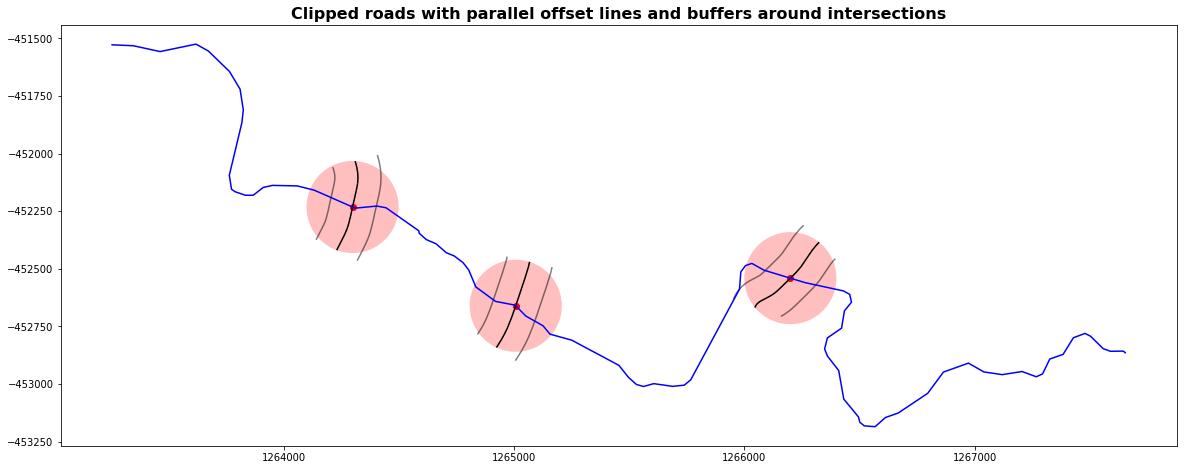

In [3]:
gdf_streams = gpd.read_file(streams)
gdf_roads = gpd.read_file(roads)

stream_prj = gdf_streams.to_crs(gdf_roads.crs)
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(200)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

single_lines = []
for road in clipped_roads:
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines.append(ops.linemerge(road))
    else:
        single_lines.append(road)
        
offset_lines = []
for side in ['left', 'right']:
    line_list = [line.parallel_offset(100, side, resolution=1) for line in single_lines]
    offset_lines = offset_lines + line_list

gdf_roads = gpd.GeoDataFrame(offset_lines, columns=['geometry'])

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines and buffers around intersections", fontsize=16, fontweight='bold');

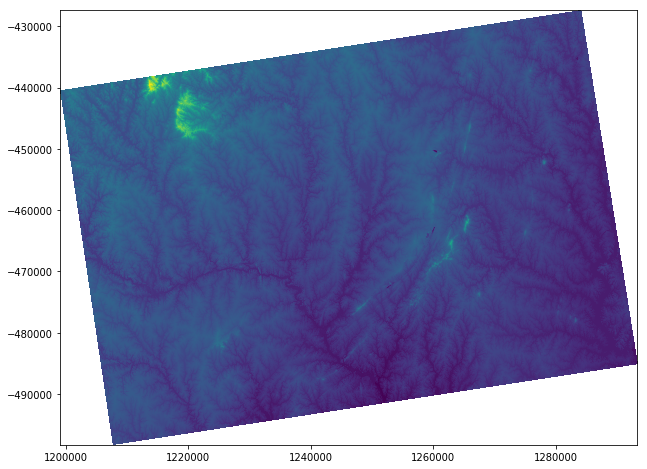

In [4]:
# Plot DEM
src = rasterio.open(dem)

fig, ax = plt.subplots(figsize = (20,8))
show(src);

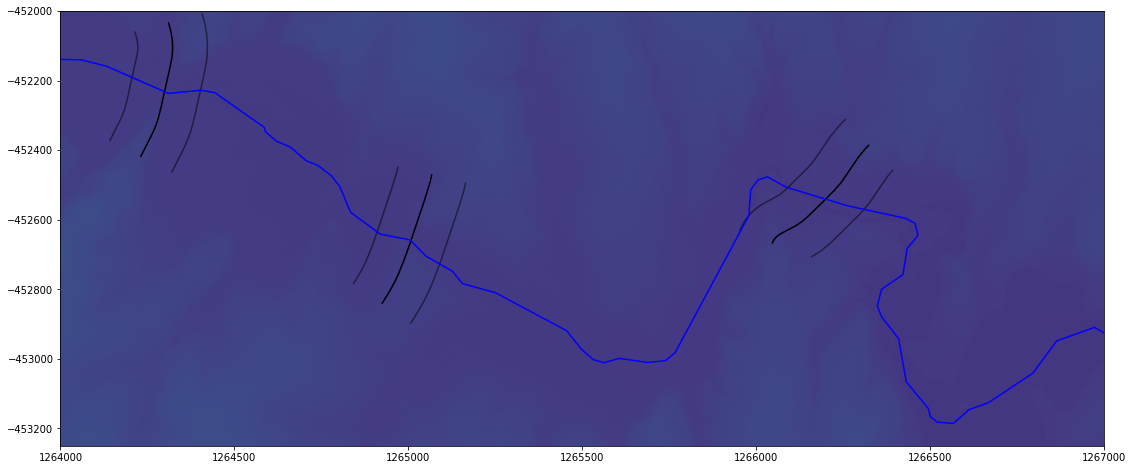

In [5]:
# Plot vector data on raster limited to vector data extent
fig, ax = plt.subplots(figsize = (20,8))
show(src, ax=ax);

clipped_roads.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);

ax.set_xlim(1_264_000, 1_267_000);
ax.set_ylim(-453_250, -452_000);

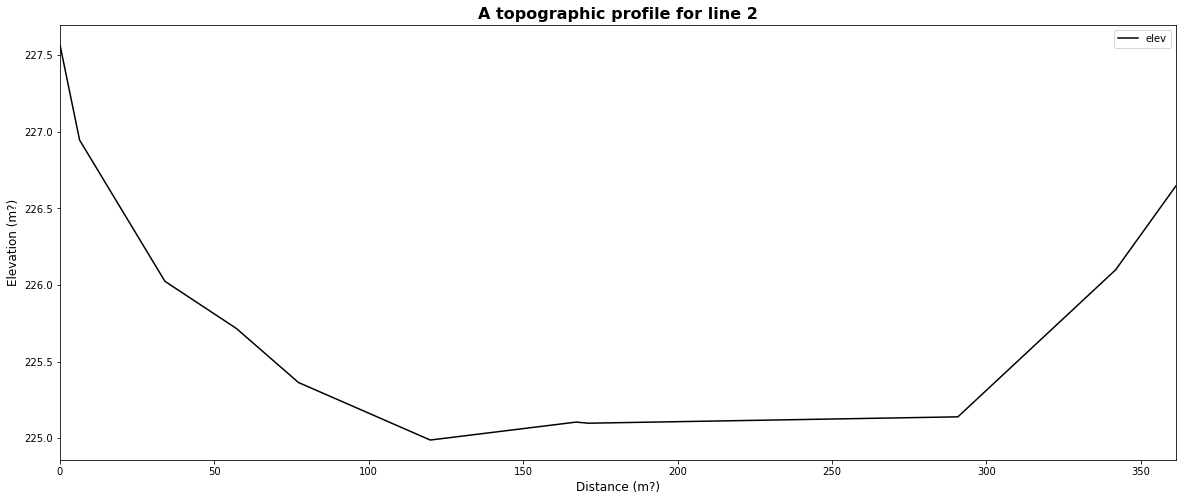

In [135]:
# Create a topographic profile
line_number = 2
profile = point_query(gdf_roads.geometry[line_number], dem)

vertecies = [Point(coord) for coord in gdf_roads.geometry[line_number].coords]
df = pd.DataFrame(vertecies, columns=['point'])
df['elev'] = profile[0]
df['distance'] = [df.point[0].distance(df.point[i]) for i in range(len(df))]

fig, ax = plt.subplots(figsize = (20,8))
df.plot(x='distance',y='elev', color='k', ax=ax);
ax.set_ylabel("Elevation (m?)", fontsize=12)
ax.set_xlabel("Distance (m?)", fontsize=12)
ax.set_title("A topographic profile for line {}".format(line_number), fontsize=16, fontweight='bold');